<a href="https://www.kaggle.com/code/houssemaminetouihri/implementation-of-cnn-s-models-and-comparison-betw?scriptVersionId=105312226" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This notebooks is for implementation and comparison of some modells



# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
import pathlib
import PIL
import time
import zipfile
import random
from tensorflow import keras as ks
from tensorflow.keras.layers import *
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Reading the data

In [2]:
train=pd.read_csv("../input/sign-recognition/Train.csv")
test=pd.read_csv("../input/sign-recognition/Test.csv")

# General insights 

In [3]:
train.shape, test.shape

((5000, 4098), (5000, 4097))

In [4]:
train.isna().sum()

ID        0
c00000    0
c00001    0
c00002    0
c00003    0
         ..
c04092    0
c04093    0
c04094    0
c04095    0
Target    0
Length: 4098, dtype: int64

# Drop ID column and define train_y , train_x , test_x

In [5]:
train_y=train['Target'].astype('float32')
train_x=train.drop(['Target','ID'],axis=1).astype('int32')
test_x=test.drop(['ID'],axis=1).astype('int32')
train_x.shape,train_y.shape,test_x.shape

((5000, 4096), (5000,), (5000, 4096))

# One Hot Encoding for train_y

In [6]:
train_y=tf.keras.utils.to_categorical(train_y,10)
train_y.shape
#'Series' object has no attribute 'reshape'

(5000, 10)

In [7]:
train_y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Reshape the size of  images and normalize them  

In [8]:
train_x=train_x.values.reshape(-1,64,64,1) #.values return an array #-1:to convert it to 1-D 
train_x=train_x/255.0
test_x=test_x.values.reshape(-1,64,64,1)
test_x/255.0
test_x.shape,train_x.shape #(nb de valeurs,the dimensions of the real image,the new dimension)
train_x.ndim,test_x.ndim

(4, 4)

In [9]:
#train_x

In [10]:
#test_x

# Plotting some exemple

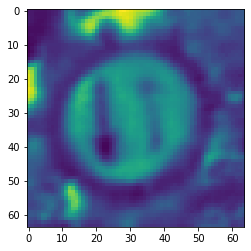

In [11]:
g =plt.imshow(train_x[150][:,:,0]) #forth dimension =1

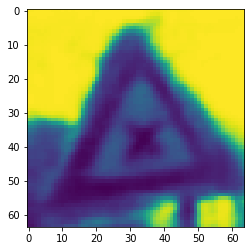

In [12]:
b = plt.imshow(test_x[500][:,:])

In [13]:
x_train , x_test, y_train , y_test=train_test_split(train_x, train_y , test_size=0.15)

In [14]:
x_train.shape , y_train.shape,x_test.shape , y_test.shape

((4250, 64, 64, 1), (4250, 10), (750, 64, 64, 1), (750, 10))

# Generating new images 

In [15]:
datagenerator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [16]:
train_generator = datagenerator.flow(x_train,y_train,)

In [17]:
validation_generator = datagenerator.flow(x_test, y_test)

# Visualizing some exemple of generating images

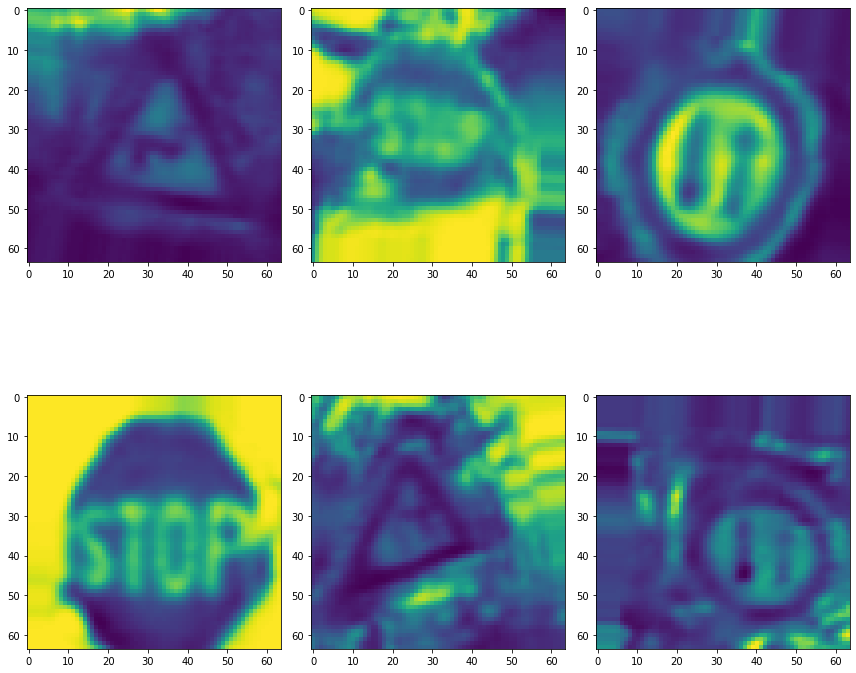

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

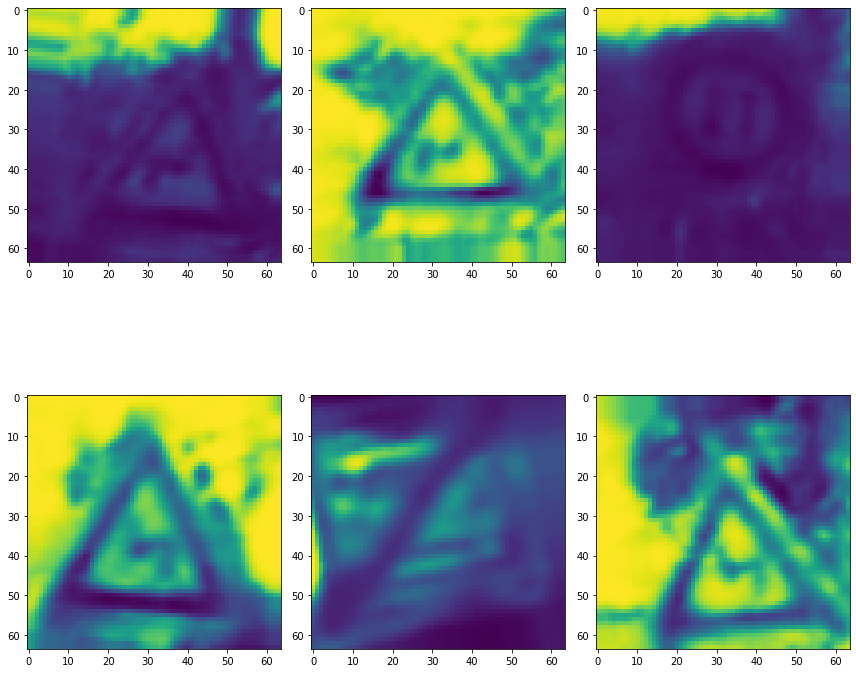

In [19]:
plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Modeling

This model is proposed by wassim chouchen (which i tried to arrange it after googling the basic cnn architecture) https://www.kaggle.com/wassimchouchen

In [20]:
model0 = ks.models.Sequential()
model0.add(ks.layers.Dense(4, input_shape=(64, 64, 1))) #units=4(we define how many outputs we want)
model0.add(ks.layers.Dense(8, input_shape=(64, 64, 1)))
model0.add(ks.layers.Dense(8, input_shape=(64, 64, 1)))
model0.add(ks.layers.Conv2D(64,(3, 3), activation='relu')) 
        #Dense layer vs convolutional layer
#Dense/fully_connected layer: A linear operation on the layer's input vector. 
#Convolutional layer: A layer that consists of a set of “filters”.
#The filters take a subset of the input data at a time, but are applied across the full input (by sweeping over the input).
#filters: Integer, the dimensionality of the output space 
#kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window.
model0.add(ks.layers.MaxPooling2D(pool_size=2, strides=2))
model0.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model0.add(ks.layers.MaxPooling2D(2, 2)) 
        #en_principe pool_size=2(it can be a tuple) window size over which to take the maximum. If only one integer is specified, the same window length will be used for both dimensions.
        #strides(integer): 2
        # Strides values. Specifies how far the pooling window moves for each pooling step. If None, it will default to pool_size.
        #pool_size: integer or tuple of 2 integers, window size over which to take the maximum. (2, 2) will take the max value over a 2x2 pooling window.
model0.add(ks.layers.Conv2D(256, (3, 3), activation='relu'))
model0.add(ks.layers.MaxPooling2D(2, 2))
model0.add(ks.layers.Conv2D(512, (3, 3), activation='relu'))
model0.add(ks.layers.MaxPooling2D(2, 2))
model0.add(ks.layers.Dropout(0.2))
        #dropout may have encouraged the network to seek out(chercher) more of the true patterns, possibly improving the validation loss some as well)
#In Keras, the dropout rate argument rate defines what percentage of the input units to shut off. 
model0.add(ks.layers.Flatten())
        #tf.keras.layers.Flatten(data_format=None, **kwargs)
        #Flattens the input. Does not affect the batch size.

#Note: If inputs are shaped (batch,) without a feature axis, then flattening adds an extra channel dimension and output shape is (batch, 1).
   # https://www.youtube.com/watch?v=efEGD1wsCnI   
model0.add(ks.layers.Dense(1024, activation='relu'))
model0.add(ks.layers.Dense(10, activation='softmax'))

model0.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
#optimizer --> The optimizer does the process of updating our parameters for us here. some kind of healer I can say. There are methods used for multiple optimizers, and you should choose the most suitable one for the model.
#loss --> It is a number that indicates how good or bad the model is to its prediction. As it approaches 0, the error starts to decrease.

2022-09-09 23:06:48.430818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 23:06:48.570674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 23:06:48.571643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 23:06:48.573563: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

trying Arranging the cnn architecture( i transformed it into a basic one) was with the help of https://www.upgrad.com/blog/basic-cnn-architecture/#:~:text=other%20advanced%20tasks.-,What%20is%20the%20architecture%20of%20CNN%3F,the%20main%20responsibility%20for%20computation.

   ![](https://www.upgrad.com/blog/wp-content/uploads/2020/12/1-4.png)

In [21]:
model1 = ks.models.Sequential()

model1.add(ks.layers.Conv2D(input_shape=(64, 64, 1),filters=64,kernel_size= (3, 3), activation='relu'))

model1.add(ks.layers.MaxPooling2D(2, 2))

model1.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(ks.layers.MaxPooling2D(2, 2))
model1.add(ks.layers.Conv2D(256, (3, 3), activation='relu'))
model1.add(ks.layers.MaxPooling2D(2, 2))

model1.add(ks.layers.Conv2D(512, (3, 3), activation='relu'))
model1.add(ks.layers.MaxPooling2D(2, 2))
model1.add(ks.layers.Dense(4, input_shape=(64, 64, 1)))
model1.add(ks.layers.Dense(8, input_shape=(64, 64, 1)))
model1.add(ks.layers.Dense(8, input_shape=(64, 64, 1)))
model1.add(ks.layers.Dropout(0.2))
  
model1.add(ks.layers.Flatten())
        
model1.add(ks.layers.Dense(1024, activation='relu'))
model1.add(ks.layers.Dense(10, activation='softmax'))

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])



# VGG16

![](https://datascientest.com/wp-content/uploads/2021/04/illu_VGG_Plan-de-travail-1.png)

In [22]:
#VGG_16
model2 = Sequential()
model2.add(Conv2D(input_shape=(64, 64, 1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Flatten())
model2.add(Dense(units=4096,activation="relu"))
model2.add(Dense(units=4096,activation="relu"))
model2.add(Dense(units=10, activation="softmax"))
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])


# VGG19

![](https://blog.techcraft.org/wp-content/uploads/2021/03/vgg19-architecture2.png)

In [23]:
#VGG19
model3 = Sequential()
    #Block 1
model3.add(Conv2D(input_shape=(64, 64, 1),filters =64,kernel_size=(3,3),padding="same", activation="relu")) 
model3.add(Conv2D(filters = 64, kernel_size = (3,3), padding="same" , activation="relu")) 
model3.add(ks.layers.MaxPool2D(pool_size=(2,2) , strides=(2,2) , padding='same')) 

#Block 2
model3.add(ks.layers.Conv2D(filters = 128, kernel_size = (3,3), padding='same' , activation='relu')) 
model3.add(ks.layers.Conv2D(filters = 128, kernel_size = (3,3), padding='same' , activation='relu'))
model3.add(ks.layers.MaxPool2D(pool_size=(2,2) , strides=(2,2) , padding='same')) 

#Block 3
model3.add(ks.layers.Conv2D(filters = 256, kernel_size = (3,3), padding='same' , activation='relu')) 
model3.add(ks.layers.Conv2D(filters = 256, kernel_size = (3,3), padding='same' , activation='relu')) 
model3.add(ks.layers.Conv2D(filters = 256, kernel_size = (3,3), padding='same' , activation='relu')) 
model3.add(ks.layers.Conv2D(filters = 256, kernel_size = (3,3), padding='same' , activation='relu')) 
model3.add(ks.layers.MaxPool2D(pool_size=(2,2) , strides=(2,2) , padding='same')) 

#Block 4
model3.add(ks.layers.Conv2D(filters = 512, kernel_size = (3,3), padding='same' , activation='relu')) 
model3.add(ks.layers.Conv2D(filters = 512, kernel_size = (3,3), padding='same' , activation='relu')) 
model3.add(ks.layers.Conv2D(filters = 512, kernel_size = (3,3), padding='same' , activation='relu')) 
model3.add(ks.layers.Conv2D(filters = 512, kernel_size = (3,3), padding='same' , activation='relu'))
model3.add(ks.layers.MaxPool2D(pool_size=(2,2) , strides=(2,2) , padding='same'))
#Block 5
model3.add(ks.layers.Conv2D(filters = 512, kernel_size = (3,3), padding='same' , activation='relu')) 
model3.add(ks.layers.Conv2D(filters = 512, kernel_size = (3,3), padding='same' , activation='relu')) 
model3.add(ks.layers.Conv2D(filters = 512, kernel_size = (3,3), padding='same' , activation='relu')) 
model3.add(ks.layers.Conv2D(filters = 512, kernel_size = (3,3), padding='same' , activation='relu')) 
model3.add(ks.layers.MaxPool2D(pool_size=(2,2) , strides=(2,2) , padding='same'))   
    #Block 6
model3.add(ks.layers.Flatten())
model3.add(ks.layers.Dense(units = 4096 , activation='relu')) 

model3.add(ks.layers.Dropout(rate = 0.2))

model3.add(ks.layers.Dense(units = 4096 , activation='relu')) 
model3.add(ks.layers.Dropout(rate = 0.2))
model3.add(ks.layers.Dense(units = 10 , activation='softmax')) 
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
##model =ks.Model(inputs = input_layer , outputs = x , name = 'VGG-19')"""

In [24]:
""""import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
# print(os.listdir("../input/flowers/flowers"))

# define parameters
CLASS_NUM = 5
BATCH_SIZE = 16
EPOCH_STEPS = int(4323/BATCH_SIZE)
IMAGE_SHAPE = (64 , 64, 1)
IMAGE_TRAIN = '../input/flowers/flowers'
MODEL_NAME = 'googlenet_flower.h5'


# create model
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model


# train model
model = googlenet()
model.summary() """

'"import os\nimport numpy as np\nimport tensorflow as tf\nimport matplotlib.pyplot as plt\nfrom tensorflow.keras import regularizers\nfrom tensorflow.keras.models import Sequential, Model\nfrom tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization\nfrom tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D\nfrom tensorflow.keras.layers import Concatenate\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\nfrom tensorflow.keras.optimizers import Adam, SGD\n# print(os.listdir("../input/flowers/flowers"))\n\n# define parameters\nCLASS_NUM = 5\nBATCH_SIZE = 16\nEPOCH_STEPS = int(4323/BATCH_SIZE)\nIMAGE_SHAPE = (64 , 64, 1)\nIMAGE_TRAIN = \'../input/flowers/flowers\'\nMODEL_NAME = \'googlenet_flower.h5\'\n\n\n# create model\ndef inception(x, filters):\n    # 1x1\n    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding=\'same\', activation=\'relu\')(x)\n\n    # 1x1->3x3\n    path2 = Conv2D(filte

# Model summary

In [25]:
model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64, 64, 4)         8         
_________________________________________________________________
dense_1 (Dense)              (None, 64, 64, 8)         40        
_________________________________________________________________
dense_2 (Dense)              (None, 64, 64, 8)         72        
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 64)        4672      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0

In [26]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 512)        

In [27]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 256)      

In [28]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 256)      

In [29]:
model0.compile(optimizer=ks.optimizers.Adam(),loss='categorical_crossentropy',metrics=['acc'])
model1.compile(optimizer=ks.optimizers.Adam(lr=0.00001),loss='categorical_crossentropy',metrics=['acc'])
model2.compile(optimizer=ks.optimizers.Adam(lr=0.00001),loss='categorical_crossentropy',metrics=['acc'])
model3.compile(optimizer=ks.optimizers.Adam(lr=0.00001),loss='categorical_crossentropy',metrics=['acc'])



In [30]:
#from keras.callbacks import ModelCheckpoint, EarlyStopping
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

##mezelou GoogLeNet and SqueezeNet

https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

In [31]:
#hist = model.fit_generator(steps_per_epoch=100,generator=train_generator,
               #            validation_data= validation_generator,
                #           validation_steps=10,epochs=100,callbacks=[checkpoint,early])


the idea behind the callback is once we detect that the aacuracy (and the validation accuracy) is starting todecrease we stop the training
This ensures that the model won't continue to learn noise and overfit the data.  besides preventing overfitting from training too long, early stopping can also prevent underfitting from not training long enough. 

In [32]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.85) and (logs.get('val_acc')>0.85):
            print('\n reached 84% accuarcy so stopping training')
            self.model.stop_training = True
callbacks = myCallback()
#the results will be 
#acc0.8614//val_acc0.8507::model0
#acc0.6680//val_acc00.6247::model1
#acc0.8402//val_acc0.8547::model2
#acc0.8381//val_acc0.8467::model3
#thats why we chose these values.


In [33]:
batch_size=5
FAST_RUN = False
epochs=20 if FAST_RUN else 100
history = model0.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(), 
        callbacks
    ]
)

2022-09-09 23:06:52.554635: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-09-09 23:06:54.977527: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


133/133 [==============================] - 11s 27ms/step - loss: 2.0755 - acc: 0.1946 - val_loss: 1.4188 - val_acc: 0.4093
Epoch 2/100
133/133 [==============================] - 3s 26ms/step - loss: 1.1376 - acc: 0.5282 - val_loss: 0.9159 - val_acc: 0.6267
Epoch 3/100
133/133 [==============================] - 3s 23ms/step - loss: 0.8006 - acc: 0.6781 - val_loss: 0.6842 - val_acc: 0.6987
Epoch 4/100
133/133 [==============================] - 4s 29ms/step - loss: 0.6487 - acc: 0.7381 - val_loss: 0.6006 - val_acc: 0.7733
Epoch 5/100
133/133 [==============================] - 3s 24ms/step - loss: 0.5943 - acc: 0.7706 - val_loss: 0.5473 - val_acc: 0.7973
Epoch 6/100
133/133 [==============================] - 4s 26ms/step - loss: 0.5730 - acc: 0.7786 - val_loss: 0.5257 - val_acc: 0.8040
Epoch 7/100
133/133 [==============================] - 3s 24ms/step - loss: 0.5255 - acc: 0.8007 - val_loss: 0.4904 - val_acc: 0.8267
Epoch 8/100
133/133 [==============================] - 3s 24ms/step - los

In [34]:
batch_size=5
FAST_RUN = False
epochs=20 if FAST_RUN else 100
history = model1.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(), 
        callbacks
    ]
)

Epoch 1/100
133/133 [==============================] - 4s 25ms/step - loss: 2.3018 - acc: 0.0932 - val_loss: 2.3005 - val_acc: 0.0987
Epoch 2/100
133/133 [==============================] - 3s 25ms/step - loss: 2.2976 - acc: 0.1045 - val_loss: 2.2923 - val_acc: 0.1120
Epoch 3/100
133/133 [==============================] - 3s 22ms/step - loss: 2.2892 - acc: 0.1125 - val_loss: 2.2800 - val_acc: 0.1480
Epoch 4/100
133/133 [==============================] - 3s 23ms/step - loss: 2.2714 - acc: 0.1344 - val_loss: 2.2513 - val_acc: 0.1573
Epoch 5/100
133/133 [==============================] - 3s 24ms/step - loss: 2.2454 - acc: 0.1452 - val_loss: 2.2097 - val_acc: 0.1827
Epoch 6/100
133/133 [==============================] - 3s 23ms/step - loss: 2.1850 - acc: 0.1779 - val_loss: 2.1328 - val_acc: 0.2187
Epoch 7/100
133/133 [==============================] - 3s 23ms/step - loss: 2.1166 - acc: 0.1899 - val_loss: 2.0562 - val_acc: 0.2320
Epoch 8/100
133/133 [==============================] - 3s 23ms

Val_acc and loss_acc are validation_accuracy and loss_accuracy
The accuracy is the percentage of correct predictions over all the observations.   
The difference between validation and test sets (and their corresponding accuracies) is that validation set is used to build/select a better model, meaning it affects the final model.  
In Validation Accuracy ,data set is used to minimise overfitting. You're not adjusting the weights of the network with this data like you do in training accuracy , you're just verifying that any increase in accuracy over the training data set actually yields an increase in accuracy over a data set that has not been introduced to the neural network before, or at least the network hasn't trained on it (i.e. validation data set).

In [35]:
batch_size=5
FAST_RUN = False
epochs=20 if FAST_RUN else 100
history = model2.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(), 
        callbacks
    ]
)

Epoch 1/100
133/133 [==============================] - 7s 43ms/step - loss: 2.2980 - acc: 0.1141 - val_loss: 2.2843 - val_acc: 0.1333
Epoch 2/100
133/133 [==============================] - 5s 35ms/step - loss: 2.2370 - acc: 0.1595 - val_loss: 2.1188 - val_acc: 0.1973
Epoch 3/100
133/133 [==============================] - 5s 36ms/step - loss: 1.8740 - acc: 0.2654 - val_loss: 1.6561 - val_acc: 0.3307
Epoch 4/100
133/133 [==============================] - 5s 35ms/step - loss: 1.5101 - acc: 0.3816 - val_loss: 1.3957 - val_acc: 0.4053
Epoch 5/100
133/133 [==============================] - 5s 37ms/step - loss: 1.3272 - acc: 0.4435 - val_loss: 1.2498 - val_acc: 0.4813
Epoch 6/100
133/133 [==============================] - 5s 41ms/step - loss: 1.2146 - acc: 0.4682 - val_loss: 1.1777 - val_acc: 0.4987
Epoch 7/100
133/133 [==============================] - 5s 35ms/step - loss: 1.1505 - acc: 0.5134 - val_loss: 1.1453 - val_acc: 0.5133
Epoch 8/100
133/133 [==============================] - 5s 36ms

In [36]:
batch_size=5
FAST_RUN = False
epochs=20 if FAST_RUN else 100
history = model3.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(), 
        callbacks
    ]
)

Epoch 1/100
133/133 [==============================] - 7s 43ms/step - loss: 2.3000 - acc: 0.1080 - val_loss: 2.2913 - val_acc: 0.1120
Epoch 2/100
133/133 [==============================] - 6s 42ms/step - loss: 2.2907 - acc: 0.1198 - val_loss: 2.2694 - val_acc: 0.1173
Epoch 3/100
133/133 [==============================] - 6s 43ms/step - loss: 2.1918 - acc: 0.1736 - val_loss: 1.9094 - val_acc: 0.2720
Epoch 4/100
133/133 [==============================] - 6s 42ms/step - loss: 1.7082 - acc: 0.3205 - val_loss: 1.4629 - val_acc: 0.3707
Epoch 5/100
133/133 [==============================] - 5s 41ms/step - loss: 1.4327 - acc: 0.3981 - val_loss: 1.2960 - val_acc: 0.4253
Epoch 6/100
133/133 [==============================] - 6s 45ms/step - loss: 1.2905 - acc: 0.4546 - val_loss: 1.2208 - val_acc: 0.4880
Epoch 7/100
133/133 [==============================] - 5s 41ms/step - loss: 1.2187 - acc: 0.4692 - val_loss: 1.1755 - val_acc: 0.5053
Epoch 8/100
133/133 [==============================] - 6s 45ms

In [37]:
'''
this model need 3 channels so it doesn't fit our problem
from tensorflow.keras.applications import VGG16


base_model = VGG16(weights = "imagenet", include_top=False, input_shape=(64, 64, 3))

#for layer in base_model.layers:
#    layer.trainable = False

base_model.compile(optimizer=ks.optimizers.Adam(lr=0.00001),loss='categorical_crossentropy',metrics=['acc'])
    
base_model.summary()
''' 

'\nthis model need 3 channels so it doesn\'t fit our problem\nfrom tensorflow.keras.applications import VGG16\n\n\nbase_model = VGG16(weights = "imagenet", include_top=False, input_shape=(64, 64, 3))\n\n#for layer in base_model.layers:\n#    layer.trainable = False\n\nbase_model.compile(optimizer=ks.optimizers.Adam(lr=0.00001),loss=\'categorical_crossentropy\',metrics=[\'acc\'])\n    \nbase_model.summary()\n'

In [38]:
#hist1 = base_model.fit_generator(steps_per_epoch=100,generator=train_generator,
 #                          validation_data= validation_generator,
  #                         validation_steps=10,epochs=100,callbacks=[checkpoint,early])


# Making Prediction


we can see that the first model is the best model

In [39]:
result3=model3.predict(test_x)
result3=np.argmax(result3,axis=1)
result3=pd.Series(result3,name="Target")

In [40]:
result3

0       0
1       8
2       2
3       7
4       6
       ..
4995    8
4996    2
4997    0
4998    1
4999    9
Name: Target, Length: 5000, dtype: int64

# submission

In [41]:
submission=pd.concat([pd.Series(range(5000),name="ID"),result3],axis=1)